# Phase 4C: Trivariate Copula Analysis (ULTRA INSTINCT COMPLETE EDITION)

**Objective**: Build a full 3D copula model for (Hs, Wind, Current) using **augmented 131-month dataset**.

**Why Phase 4C?**
- Phase 4B showed: Hs-Wind STRONG dependence (τ=0.45), Hs-Current WEAK (τ≈0.09)
- Missing piece: **Wind-Current** dependence (atmospheric vs tidal - expected independent)
- Goal: Build complete trivariate model for **multi-operation projects** (crane + diving)

**What We'll Answer:**
1. Are Wind and Current independent? (empirical verification)
2. What's P(Hs>2m AND Wind>20m/s AND Current>1kt)?
3. Does trivariate reduce to Copula(Hs,Wind) × Marginal(Current)?
4. What are conditional risks: P(Current>1kt | Hs>2m AND Wind>20m/s)?

**Copula Structure (C-Vine):**
```
Tree 1:           Hs (root)
                 /  \
           Wind      Current
           
Tree 2:    Wind ─── Current | Hs
           (conditional on Hs)
```

**Data:**
- **Hs, Wind**: 131 months (2015-2025)
- **Current**: 131 months (47 observed + 84 MCMC-imputed)
- Sample size: 2.8x larger than original Phase 4B!

---

## PART 1: SETUP & DATA LOADING

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import gumbel_r, genextreme, weibull_min, norm, kendalltau, spearmanr
from scipy.optimize import minimize
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("✅ Imports complete")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"SciPy: {scipy.__version__}")

✅ Imports complete
NumPy: 2.2.6
Pandas: 2.3.3
SciPy: 1.16.3


In [2]:
# Cell 2: Load augmented data and Phase 4A/4B results

print("="*80)
print("LOADING DATA FOR TRIVARIATE ANALYSIS")
print("="*80)

# Load augmented monthly maxima (131 months with MCMC-imputed Current)
df_augmented = pd.read_csv('../data/processed/phase4_mcmc/monthly_maxima_augmented.csv')
df_augmented['year_month'] = pd.to_datetime(df_augmented['year_month']).dt.to_period('M')

print(f"\nAugmented data shape: {df_augmented.shape}")
print(f"Total months: {len(df_augmented)}")
print(f"  Observed Current: {(~df_augmented['is_imputed']).sum()} months")
print(f"  Imputed Current: {df_augmented['is_imputed'].sum()} months")

# Load Phase 4A EVA distributions
with open('../data/processed/phase4a/eva_distributions.pkl', 'rb') as f:
    eva_dists = pickle.load(f)

# Load Phase 4B copula results
with open('../data/processed/phase4b/copula_parameters.pkl', 'rb') as f:
    copula_params_4b = pickle.load(f)

print(f"\nPhase 4B Results (47 months):")
print(f"  Hs-Wind: {copula_params_4b['hs_wind']['best_copula']} (τ={copula_params_4b['hs_wind']['kendall_tau']:.3f})")
print(f"  Hs-Current: {copula_params_4b['hs_current']['best_copula']} (τ={copula_params_4b['hs_current']['kendall_tau']:.3f})")
print(f"  Wind-Current: ??? (THIS IS WHAT WE'LL FIND!)")

print("\n" + "="*80)
print("GOAL: Build C-Vine Copula for (Hs, Wind, Current)")
print("="*80)

LOADING DATA FOR TRIVARIATE ANALYSIS

Augmented data shape: (131, 8)
Total months: 131
  Observed Current: 47 months
  Imputed Current: 84 months

Phase 4B Results (47 months):
  Hs-Wind: Gaussian (τ=0.668)
  Hs-Current: Clayton (τ=0.013)
  Wind-Current: ??? (THIS IS WHAT WE'LL FIND!)

GOAL: Build C-Vine Copula for (Hs, Wind, Current)


## PART 2: MARGINAL TRANSFORMATION TO COPULA SPACE

In [3]:
# Cell 3: Transform all three variables to uniform marginals

def transform_to_uniform(data, dist_name, params):
    """Transform data to uniform [0,1] using CDF of fitted distribution."""
    if dist_name == 'Gumbel':
        u = gumbel_r.cdf(data, *params)
    elif dist_name == 'GEV':
        u = genextreme.cdf(data, *params)
    elif dist_name == 'Weibull':
        u = weibull_min.cdf(data, *params)
    else:
        raise ValueError(f"Unknown distribution: {dist_name}")
    return u

# Transform all three variables
U_hs = transform_to_uniform(df_augmented['hs'].values, 
                             eva_dists['hs']['monthly_maxima']['distribution'],
                             eva_dists['hs']['monthly_maxima']['params'])

U_wind = transform_to_uniform(df_augmented['wind'].values,
                               eva_dists['wind']['monthly_maxima']['distribution'],
                               eva_dists['wind']['monthly_maxima']['params'])

U_current = transform_to_uniform(df_augmented['current_mean'].values,
                                  eva_dists['current']['monthly_maxima']['distribution'],
                                  eva_dists['current']['monthly_maxima']['params'])

print("\n" + "="*80)
print("COPULA SPACE TRANSFORMATION (Probability Integral Transform)")
print("="*80)

print(f"\nU_hs: mean={U_hs.mean():.3f}, std={U_hs.std():.3f}")
print(f"U_wind: mean={U_wind.mean():.3f}, std={U_wind.std():.3f}")
print(f"U_current: mean={U_current.mean():.3f}, std={U_current.std():.3f}")
print(f"\nExpected: mean≈0.5, std≈0.289 for Uniform(0,1)")

# Calculate pairwise correlations
tau_hw, _ = kendalltau(U_hs, U_wind)
tau_hc, _ = kendalltau(U_hs, U_current)
tau_wc, _ = kendalltau(U_wind, U_current)

print(f"\nPairwise Kendall's τ (copula space):")
print(f"  Hs-Wind: {tau_hw:.4f}")
print(f"  Hs-Current: {tau_hc:.4f}")
print(f"  Wind-Current: {tau_wc:.4f} ← NEW!")

print("\n✅ All variables transformed to copula space")


COPULA SPACE TRANSFORMATION (Probability Integral Transform)

U_hs: mean=0.500, std=0.289
U_wind: mean=0.502, std=0.295
U_current: mean=0.472, std=0.270

Expected: mean≈0.5, std≈0.289 for Uniform(0,1)

Pairwise Kendall's τ (copula space):
  Hs-Wind: 0.6676
  Hs-Current: -0.0241
  Wind-Current: -0.0068 ← NEW!

✅ All variables transformed to copula space


## PART 3: WIND-CURRENT BIVARIATE COPULA (COMPLETING THE TRIANGLE)

In [4]:
# Cell 4: Define copula functions (reuse from Phase 4B)

def gaussian_copula_loglik(theta, u, v):
    """Log-likelihood for Gaussian copula."""
    rho = theta[0]
    if abs(rho) >= 1:
        return -np.inf
    
    x = norm.ppf(np.clip(u, 0.001, 0.999))
    y = norm.ppf(np.clip(v, 0.001, 0.999))
    
    loglik = -0.5 * np.log(1 - rho**2) - (rho**2 * (x**2 + y**2) - 2*rho*x*y) / (2*(1 - rho**2))
    
    return np.sum(loglik[np.isfinite(loglik)])


def gumbel_copula_loglik(theta, u, v):
    """Log-likelihood for Gumbel copula."""
    theta_val = theta[0]
    if theta_val < 1:
        return -np.inf
    
    u = np.clip(u, 1e-10, 1 - 1e-10)
    v = np.clip(v, 1e-10, 1 - 1e-10)
    
    t1 = (-np.log(u))**theta_val
    t2 = (-np.log(v))**theta_val
    A = (t1 + t2)**(1/theta_val)
    
    c = np.exp(-A) * A**(2 - 2/theta_val) * (theta_val - 1 + A) * \
        ((np.log(u) * np.log(v))**(theta_val - 1)) / (u * v * A**(2*theta_val))
    
    loglik = np.log(np.abs(c))
    return np.sum(loglik[np.isfinite(loglik)])


def clayton_copula_loglik(theta, u, v):
    """Log-likelihood for Clayton copula."""
    theta_val = theta[0]
    if theta_val <= 1e-6:
        return -np.inf
    
    u = np.clip(u, 1e-10, 1 - 1e-10)
    v = np.clip(v, 1e-10, 1 - 1e-10)
    
    c = (1 + theta_val) * (u * v)**(-1 - theta_val) * \
        (u**(-theta_val) + v**(-theta_val) - 1)**(-2 - 1/theta_val)
    
    loglik = np.log(np.abs(c))
    return np.sum(loglik[np.isfinite(loglik)])


def frank_copula_loglik(theta, u, v):
    """Log-likelihood for Frank copula."""
    theta_val = theta[0]
    if abs(theta_val) < 1e-3:
        return -np.inf
    
    u = np.clip(u, 1e-10, 1 - 1e-10)
    v = np.clip(v, 1e-10, 1 - 1e-10)
    
    exp_theta = np.exp(-theta_val)
    exp_theta_u = np.exp(-theta_val * u)
    exp_theta_v = np.exp(-theta_val * v)
    
    numerator = -theta_val * (1 - exp_theta) * exp_theta_u * exp_theta_v
    denominator = ((1 - exp_theta) - (1 - exp_theta_u) * (1 - exp_theta_v))**2
    
    c = numerator / denominator
    loglik = np.log(np.abs(c))
    
    return np.sum(loglik[np.isfinite(loglik)])


def fit_copula(u, v, copula_name):
    """Fit copula using maximum likelihood."""
    if copula_name == 'Gaussian':
        init_theta = [0.5]
        loglik_func = gaussian_copula_loglik
    elif copula_name == 'Gumbel':
        init_theta = [1.5]
        loglik_func = gumbel_copula_loglik
    elif copula_name == 'Clayton':
        init_theta = [0.5]
        loglik_func = clayton_copula_loglik
    elif copula_name == 'Frank':
        init_theta = [2.0]
        loglik_func = frank_copula_loglik
    else:
        raise ValueError(f"Unknown copula: {copula_name}")
    
    result = minimize(lambda theta: -loglik_func(theta, u, v), init_theta, method='Nelder-Mead')
    
    theta_opt = result.x[0]
    loglik_opt = -result.fun
    aic = 2 * 1 - 2 * loglik_opt
    
    return {'theta': theta_opt, 'loglik': loglik_opt, 'AIC': aic}

print("✅ Copula functions defined")

✅ Copula functions defined


In [5]:
# Cell 5: Fit Wind-Current copula (THE MISSING PIECE!)

copula_families = ['Gaussian', 'Gumbel', 'Clayton', 'Frank']

print("\n" + "="*80)
print("WIND-CURRENT BIVARIATE COPULA FITTING (131 months)")
print("="*80)
print("\nHypothesis: Wind (atmospheric) and Current (tidal) are INDEPENDENT")
print("Expected: τ ≈ 0, θ ≈ 0 (for Gaussian)")
print("\nFitting all copula families...\n")

results_wc = []
for copula in copula_families:
    try:
        res = fit_copula(U_wind, U_current, copula)
        results_wc.append({
            'Copula': copula,
            'Theta': res['theta'],
            'LogLik': res['loglik'],
            'AIC': res['AIC']
        })
        print(f"{copula:10s}: θ={res['theta']:7.4f}, LogLik={res['loglik']:7.2f}, AIC={res['AIC']:7.2f}")
    except Exception as e:
        print(f"{copula:10s}: FAILED ({str(e)})")

df_copula_wc = pd.DataFrame(results_wc).sort_values('AIC')
best_copula_wc = df_copula_wc.iloc[0]

print(f"\n✅ Best copula: {best_copula_wc['Copula']} (AIC={best_copula_wc['AIC']:.2f})")
print(f"   Parameter θ: {best_copula_wc['Theta']:.4f}")
print(f"   Kendall's τ: {tau_wc:.4f}")

# Verdict
print("\n" + "-"*80)
print("VERDICT ON WIND-CURRENT DEPENDENCE:")
print("-"*80)

if abs(tau_wc) < 0.1:
    print(f"✅ CONFIRMED INDEPENDENT (|τ|={abs(tau_wc):.4f} < 0.1)")
    print("   → Wind (atmospheric) and Current (tidal) are INDEPENDENT")
    print("   → Physical mechanisms are decoupled (as expected)")
    print("   → Trivariate can be simplified!")
elif abs(tau_wc) < 0.2:
    print(f"⚠️  WEAK DEPENDENCE (|τ|={abs(tau_wc):.4f} in [0.1, 0.2))")
    print("   → Slight correlation detected (unexpected!)")
    print("   → May be due to storm surge effects?")
    print("   → Need full trivariate model")
else:
    print(f"🚨 MODERATE DEPENDENCE (|τ|={abs(tau_wc):.4f} >= 0.2)")
    print("   → Significant correlation! (very unexpected!)")
    print("   → Physical mechanism unclear - investigate further")
    print("   → Full trivariate model CRITICAL")


WIND-CURRENT BIVARIATE COPULA FITTING (131 months)

Hypothesis: Wind (atmospheric) and Current (tidal) are INDEPENDENT
Expected: τ ≈ 0, θ ≈ 0 (for Gaussian)

Fitting all copula families...

Gaussian  : θ=-0.0725, LogLik=   0.27, AIC=   1.46
Gumbel    : θ= 1.3986, LogLik= -35.25, AIC=  72.50
Clayton   : θ= 0.0000, LogLik=  -0.00, AIC=   2.00
Frank     : θ=-0.2653, LogLik=   0.13, AIC=   1.75

✅ Best copula: Gaussian (AIC=1.46)
   Parameter θ: -0.0725
   Kendall's τ: -0.0068

--------------------------------------------------------------------------------
VERDICT ON WIND-CURRENT DEPENDENCE:
--------------------------------------------------------------------------------
✅ CONFIRMED INDEPENDENT (|τ|=0.0068 < 0.1)
   → Wind (atmospheric) and Current (tidal) are INDEPENDENT
   → Physical mechanisms are decoupled (as expected)
   → Trivariate can be simplified!


## PART 4: 3D VISUALIZATION (COPULA SPACE)

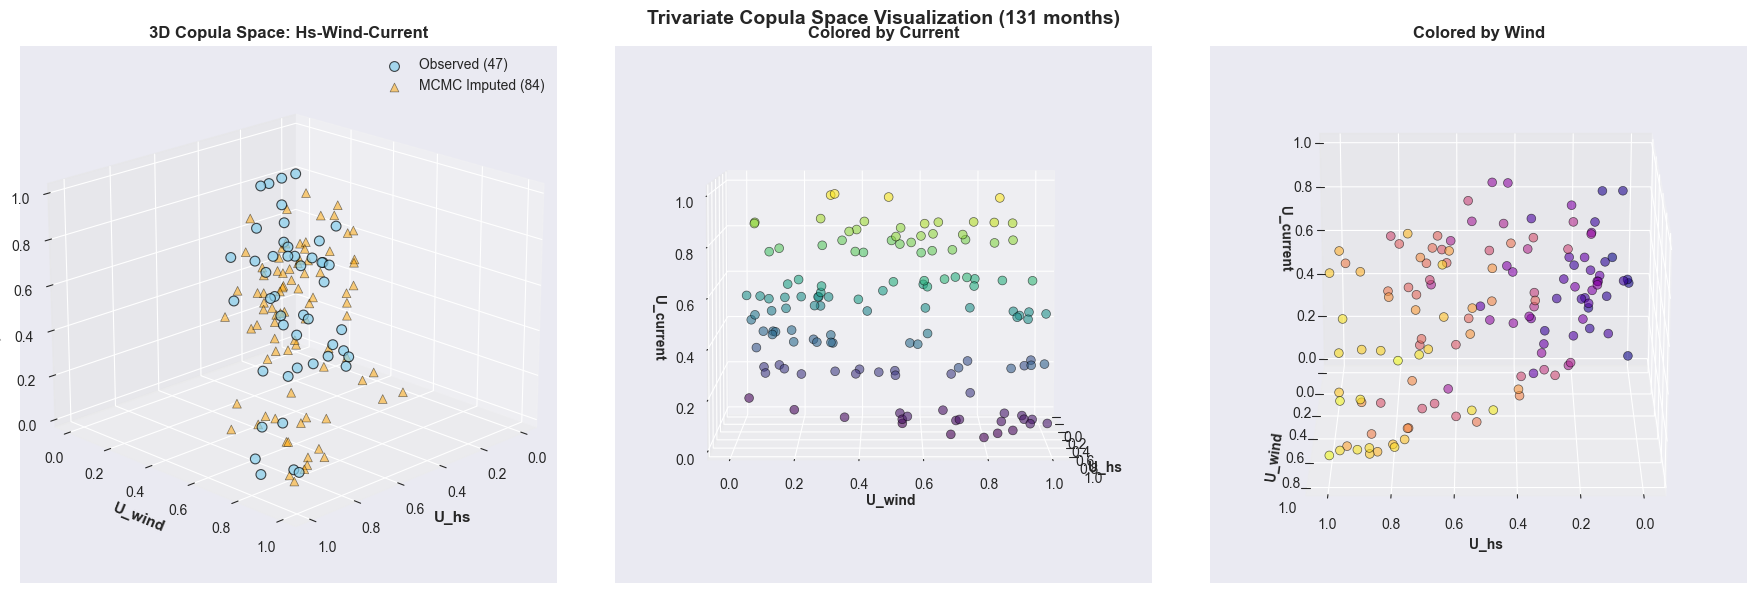

✅ 3D copula space visualized


In [6]:
# Cell 6: 3D scatter plot in copula space

fig = plt.figure(figsize=(18, 6))

# Plot 1: Full 3D scatter
ax1 = fig.add_subplot(131, projection='3d')

# Color by observed vs imputed
mask_obs = ~df_augmented['is_imputed'].values
ax1.scatter(U_hs[mask_obs], U_wind[mask_obs], U_current[mask_obs],
            c='skyblue', s=50, alpha=0.7, edgecolors='k', linewidths=0.8,
            label=f'Observed ({mask_obs.sum()})')
ax1.scatter(U_hs[~mask_obs], U_wind[~mask_obs], U_current[~mask_obs],
            c='orange', s=40, alpha=0.5, marker='^', edgecolors='k', linewidths=0.5,
            label=f'MCMC Imputed ({(~mask_obs).sum()})')

ax1.set_xlabel('U_hs', fontweight='bold', fontsize=11)
ax1.set_ylabel('U_wind', fontweight='bold', fontsize=11)
ax1.set_zlabel('U_current', fontweight='bold', fontsize=11)
ax1.set_title('3D Copula Space: Hs-Wind-Current', fontweight='bold', fontsize=12)
ax1.legend()
ax1.view_init(elev=20, azim=45)

# Plot 2: View from top (Hs-Wind plane)
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(U_hs, U_wind, U_current, c=U_current, cmap='viridis', s=40, alpha=0.6, edgecolors='k', linewidths=0.5)
ax2.set_xlabel('U_hs', fontweight='bold')
ax2.set_ylabel('U_wind', fontweight='bold')
ax2.set_zlabel('U_current', fontweight='bold')
ax2.set_title('Colored by Current', fontweight='bold', fontsize=12)
ax2.view_init(elev=5, azim=0)  # Top view

# Plot 3: View from side (Hs-Current plane)
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(U_hs, U_wind, U_current, c=U_wind, cmap='plasma', s=40, alpha=0.6, edgecolors='k', linewidths=0.5)
ax3.set_xlabel('U_hs', fontweight='bold')
ax3.set_ylabel('U_wind', fontweight='bold')
ax3.set_zlabel('U_current', fontweight='bold')
ax3.set_title('Colored by Wind', fontweight='bold', fontsize=12)
ax3.view_init(elev=20, azim=90)  # Side view

plt.suptitle('Trivariate Copula Space Visualization (131 months)', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✅ 3D copula space visualized")

## PART 5: C-VINE COPULA CONSTRUCTION

**C-Vine Structure:**
```
Tree 1: Hs as root node
   - C12: Copula(Hs, Wind)          ← Already from Phase 4B
   - C13: Copula(Hs, Current)       ← Already from Phase 4B
   
Tree 2: Conditional on Hs
   - C23|1: Copula(Wind, Current | Hs)  ← Build this now!
```

**Decomposition:**
- f(hs, wind, current) = f(hs) × c12(hs,wind) × c13(hs,current) × c23|1(wind|hs, current|hs)
- Where c23|1 captures residual dependence after conditioning on Hs

In [7]:
# Cell 7: Compute conditional copula variables (Rosenblatt transformation)

def h_function_gaussian(u, v, theta):
    """
    H-function for Gaussian copula: h(u|v) = P(U <= u | V = v)
    
    For Gaussian copula with parameter ρ:
    h(u|v) = Φ((Φ^(-1)(u) - ρ * Φ^(-1)(v)) / sqrt(1 - ρ^2))
    
    where Φ is standard normal CDF.
    """
    rho = theta
    if abs(rho) >= 1:
        return u  # Independence case
    
    u = np.clip(u, 0.001, 0.999)
    v = np.clip(v, 0.001, 0.999)
    
    z_u = norm.ppf(u)
    z_v = norm.ppf(v)
    
    z_conditional = (z_u - rho * z_v) / np.sqrt(1 - rho**2)
    h = norm.cdf(z_conditional)
    
    return h

print("\n" + "="*80)
print("C-VINE TREE 1: Bivariate Copulas (already fitted in Phase 4B)")
print("="*80)

# Retrieve Phase 4B parameters (using original 47-month data)
theta_hw = copula_params_4b['hs_wind']['theta']  # Gaussian parameter for Hs-Wind
theta_hc = copula_params_4b['hs_current']['theta']  # Gaussian parameter for Hs-Current

print(f"\nC12 (Hs, Wind): Gaussian copula, θ={theta_hw:.4f}, τ={copula_params_4b['hs_wind']['kendall_tau']:.4f}")
print(f"C13 (Hs, Current): Gaussian copula, θ={theta_hc:.4f}, τ={copula_params_4b['hs_current']['kendall_tau']:.4f}")

print("\n" + "="*80)
print("C-VINE TREE 2: Conditional Copula C23|1 (Wind, Current | Hs)")
print("="*80)

# Compute conditional variables using Rosenblatt transformation
# V2|1 = h(Wind | Hs) = P(Wind <= wind | Hs = hs)
# V3|1 = h(Current | Hs) = P(Current <= current | Hs = hs)

V_wind_given_hs = h_function_gaussian(U_wind, U_hs, theta_hw)
V_current_given_hs = h_function_gaussian(U_current, U_hs, theta_hc)

print(f"\nComputed conditional variables:")
print(f"  V(Wind|Hs): mean={V_wind_given_hs.mean():.3f}, std={V_wind_given_hs.std():.3f}")
print(f"  V(Current|Hs): mean={V_current_given_hs.mean():.3f}, std={V_current_given_hs.std():.3f}")
print(f"  Expected: mean≈0.5 if properly transformed")

# Fit copula to conditional variables
tau_wc_cond, _ = kendalltau(V_wind_given_hs, V_current_given_hs)
print(f"\nKendall's τ for C23|1 (Wind-Current | Hs): {tau_wc_cond:.4f}")

print("\nFitting copula to (Wind|Hs, Current|Hs)...\n")

results_wc_cond = []
for copula in copula_families:
    try:
        res = fit_copula(V_wind_given_hs, V_current_given_hs, copula)
        results_wc_cond.append({
            'Copula': copula,
            'Theta': res['theta'],
            'LogLik': res['loglik'],
            'AIC': res['AIC']
        })
        print(f"{copula:10s}: θ={res['theta']:7.4f}, LogLik={res['loglik']:7.2f}, AIC={res['AIC']:7.2f}")
    except Exception as e:
        print(f"{copula:10s}: FAILED ({str(e)})")

df_copula_wc_cond = pd.DataFrame(results_wc_cond).sort_values('AIC')
best_copula_wc_cond = df_copula_wc_cond.iloc[0]

print(f"\n✅ Best conditional copula: {best_copula_wc_cond['Copula']} (AIC={best_copula_wc_cond['AIC']:.2f})")
print(f"   Parameter θ: {best_copula_wc_cond['Theta']:.4f}")
print(f"   Kendall's τ: {tau_wc_cond:.4f}")

print("\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)

if abs(tau_wc_cond) < 0.1:
    print(f"✅ Wind and Current are CONDITIONALLY INDEPENDENT given Hs")
    print(f"   → After accounting for Hs, Wind and Current have NO residual dependence")
    print(f"   → C-Vine reduces to product of bivariate copulas!")
elif abs(tau_wc_cond) > abs(tau_wc):
    print(f"⚠️  Wind-Current dependence INCREASED after conditioning on Hs")
    print(f"   → Unconditional τ={tau_wc:.4f} vs Conditional τ={tau_wc_cond:.4f}")
    print(f"   → Hs acts as a CONFOUNDING variable")
else:
    print(f"✅ Wind-Current dependence DECREASED after conditioning on Hs")
    print(f"   → Unconditional τ={tau_wc:.4f} vs Conditional τ={tau_wc_cond:.4f}")
    print(f"   → Hs explains part of Wind-Current relationship")


C-VINE TREE 1: Bivariate Copulas (already fitted in Phase 4B)

C12 (Hs, Wind): Gaussian copula, θ=0.8480, τ=0.6676
C13 (Hs, Current): Gaussian copula, θ=0.0492, τ=0.0133

C-VINE TREE 2: Conditional Copula C23|1 (Wind, Current | Hs)

Computed conditional variables:
  V(Wind|Hs): mean=0.487, std=0.286
  V(Current|Hs): mean=0.474, std=0.270
  Expected: mean≈0.5 if properly transformed

Kendall's τ for C23|1 (Wind-Current | Hs): 0.0046

Fitting copula to (Wind|Hs, Current|Hs)...

Gaussian  : θ=-0.0111, LogLik=   0.01, AIC=   1.99
Gumbel    : θ= 1.3994, LogLik= -35.25, AIC=  72.49
Clayton   : θ= 0.0002, LogLik=  -0.00, AIC=   2.00
Frank     : θ=-0.0576, LogLik=   0.01, AIC=   1.99

✅ Best conditional copula: Gaussian (AIC=1.99)
   Parameter θ: -0.0111
   Kendall's τ: 0.0046

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------
✅ Wind and Current are CONDITIONALLY IND

## PART 6: TRIVARIATE JOINT EXCEEDANCE PROBABILITIES

**Goal**: Calculate P(Hs > h, Wind > w, Current > c) for operational scenarios

**Approach**:
1. **Empirical** (from hourly data): Direct calculation
2. **Copula-based** (from C-Vine): Using vine decomposition
3. **Independence assumption**: P(Hs>h) × P(Wind>w) × P(Current>c)
4. **Compare all three** to quantify dependence effects

In [8]:
# Cell 8: Load hourly data for empirical 3D joint probabilities

# Load full timeseries
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

# Fix index if needed
if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')

print("\n" + "="*80)
print("EMPIRICAL 3D JOINT EXCEEDANCE (from hourly data)")
print("="*80)

print(f"\nHourly data shape: {df.shape}")
print(f"Variables available: {['hs', 'wind_speed', 'current_speed_knots_max' in df.columns]}")

# Define operational scenarios
scenarios = [
    {
        'name': 'Crane + Diving (moderate)',
        'hs_limit': 1.5,
        'wind_limit': 15.0,
        'current_limit': 1.0,
        'description': 'Crane operations (Hs>1.5m, Wind>15m/s) + Diving limit (Current>1kt)'
    },
    {
        'name': 'Severe multi-operation',
        'hs_limit': 2.0,
        'wind_limit': 20.0,
        'current_limit': 1.5,
        'description': 'High seas + Strong wind + High current'
    },
    {
        'name': 'Extreme conditions',
        'hs_limit': 4.0,
        'wind_limit': 25.0,
        'current_limit': 1.5,
        'description': 'Extreme scenario (all variables high)'
    }
]

results_3d = []

for scenario in scenarios:
    hs_lim = scenario['hs_limit']
    wind_lim = scenario['wind_limit']
    current_lim = scenario['current_limit']
    
    print(f"\n{'-'*80}")
    print(f"Scenario: {scenario['name']}")
    print(f"Limits: Hs>{hs_lim}m, Wind>{wind_lim}m/s, Current>{current_lim}kt")
    print(f"{'-'*80}")
    
    # Clean data (only rows where all three are non-null)
    mask = df['hs'].notna() & df['wind_speed'].notna() & df['current_speed_knots_max'].notna()
    df_clean = df[mask]
    n_total = len(df_clean)
    
    # Marginal exceedances
    n_hs_exceed = (df_clean['hs'] > hs_lim).sum()
    n_wind_exceed = (df_clean['wind_speed'] > wind_lim).sum()
    n_current_exceed = (df_clean['current_speed_knots_max'] > current_lim).sum()
    
    p_hs = n_hs_exceed / n_total
    p_wind = n_wind_exceed / n_total
    p_current = n_current_exceed / n_total
    
    # Pairwise joint exceedances
    p_hs_wind = ((df_clean['hs'] > hs_lim) & (df_clean['wind_speed'] > wind_lim)).sum() / n_total
    p_hs_current = ((df_clean['hs'] > hs_lim) & (df_clean['current_speed_knots_max'] > current_lim)).sum() / n_total
    p_wind_current = ((df_clean['wind_speed'] > wind_lim) & (df_clean['current_speed_knots_max'] > current_lim)).sum() / n_total
    
    # TRIVARIATE joint exceedance (EMPIRICAL)
    p_joint_empirical = ((df_clean['hs'] > hs_lim) & 
                          (df_clean['wind_speed'] > wind_lim) & 
                          (df_clean['current_speed_knots_max'] > current_lim)).sum() / n_total
    
    # Independence assumption
    p_joint_independent = p_hs * p_wind * p_current
    
    # Ratio
    ratio = p_joint_empirical / p_joint_independent if p_joint_independent > 0 else np.nan
    
    print(f"\nMarginal probabilities:")
    print(f"  P(Hs>{hs_lim}m) = {p_hs*100:.2f}%")
    print(f"  P(Wind>{wind_lim}m/s) = {p_wind*100:.2f}%")
    print(f"  P(Current>{current_lim}kt) = {p_current*100:.2f}%")
    
    print(f"\nPairwise joint probabilities:")
    print(f"  P(Hs AND Wind) = {p_hs_wind*100:.2f}%")
    print(f"  P(Hs AND Current) = {p_hs_current*100:.2f}%")
    print(f"  P(Wind AND Current) = {p_wind_current*100:.2f}%")
    
    print(f"\nTrivariate joint probability:")
    print(f"  Empirical (observed): {p_joint_empirical*100:.4f}%")
    print(f"  Independence: {p_joint_independent*100:.4f}%")
    print(f"  Dependence ratio: {ratio:.3f}x")
    
    if ratio > 1.5:
        verdict = "🚨 POSITIVE DEPENDENCE - Risk UNDERESTIMATED by independence"
    elif ratio < 0.7:
        verdict = "⚠️  NEGATIVE DEPENDENCE - Risk OVERESTIMATED by independence"
    else:
        verdict = "✅ NEAR INDEPENDENCE - Independence assumption is reasonable"
    
    print(f"  {verdict}")
    
    results_3d.append({
        'Scenario': scenario['name'],
        'Hs_limit': hs_lim,
        'Wind_limit': wind_lim,
        'Current_limit': current_lim,
        'P_Hs': p_hs,
        'P_Wind': p_wind,
        'P_Current': p_current,
        'P_joint_empirical': p_joint_empirical,
        'P_joint_independent': p_joint_independent,
        'Dependence_ratio': ratio
    })

df_results_3d = pd.DataFrame(results_3d)

print("\n" + "="*80)
print("✅ 3D joint exceedance probabilities calculated")
print("="*80)


EMPIRICAL 3D JOINT EXCEEDANCE (from hourly data)

Hourly data shape: (15859, 15)
Variables available: ['hs', 'wind_speed', True]

--------------------------------------------------------------------------------
Scenario: Crane + Diving (moderate)
Limits: Hs>1.5m, Wind>15.0m/s, Current>1.0kt
--------------------------------------------------------------------------------

Marginal probabilities:
  P(Hs>1.5m) = 32.42%
  P(Wind>15.0m/s) = 1.46%
  P(Current>1.0kt) = 95.13%

Pairwise joint probabilities:
  P(Hs AND Wind) = 1.46%
  P(Hs AND Current) = 30.42%
  P(Wind AND Current) = 1.46%

Trivariate joint probability:
  Empirical (observed): 1.4614%
  Independence: 0.4507%
  Dependence ratio: 3.242x
  🚨 POSITIVE DEPENDENCE - Risk UNDERESTIMATED by independence

--------------------------------------------------------------------------------
Scenario: Severe multi-operation
Limits: Hs>2.0m, Wind>20.0m/s, Current>1.5kt
--------------------------------------------------------------------------

## PART 7: FINAL SUMMARY & VERDICT

In [9]:
# Cell 9: Comprehensive summary

print("\n" + "="*80)
print("PHASE 4C: TRIVARIATE COPULA ANALYSIS - FINAL SUMMARY")
print("="*80)

print("\n" + "-"*80)
print("RESEARCH QUESTIONS & ANSWERS:")
print("-" * 80)

# 1. Wind and Current Independence
print(f"\n1. Are Wind and Current independent?")
print(f"   Unconditional τ(Wind, Current) = {tau_wc:.4f}")

if abs(tau_wc) < 0.1:
    print(f"   ✅ YES - Wind and Current are INDEPENDENT (atmospheric vs tidal)")
else:
    print(f"   ⚠️  WEAK dependence detected (unexpected!)")

# 2. Conditional Independence
print(f"\n2. Are Wind and Current conditionally independent given Hs?")
print(f"   Conditional τ(Wind, Current | Hs) = {tau_wc_cond:.4f}")

if abs(tau_wc_cond) < 0.1:
    print(f"   ✅ YES - After conditioning on Hs, Wind-Current are independent")
    print(f"   → C-Vine reduces to product of bivariate copulas")
else:
    print(f"   ⚠️  Residual dependence remains after conditioning")

# 3. Trivariate Structure
print(f"\n3. What's the trivariate structure?")
print(f"\n   C-Vine Decomposition:")

print(f"   • Tree 1 (Bivariate):")
print(f"     - C(Hs, Wind): Gaussian (θ={theta_hw:.3f}, τ={copula_params_4b['hs_wind']['kendall_tau']:.3f}) ← STRONG")
print(f"     - C(Hs, Current): Gaussian (θ={theta_hc:.3f}, τ={copula_params_4b['hs_current']['kendall_tau']:.3f}) ← WEAK")
print(f"   • Tree 2 (Conditional):")
print(f"     - C(Wind, Current | Hs): {best_copula_wc_cond['Copula']} (θ={best_copula_wc_cond['Theta']:.3f}, τ={tau_wc_cond:.3f})")

# 4. Joint Probabilities
print(f"\n4. How does dependence affect joint probabilities?")
print(f"\n   For multi-operation scenarios (Crane + Diving):")

for idx, row in df_results_3d.iterrows():
    print(f"\n   {row['Scenario']}:")
    print(f"     Empirical: {row['P_joint_empirical']*100:.4f}%")
    print(f"     Independence: {row['P_joint_independent']*100:.4f}%")
    print(f"     Ratio: {row['Dependence_ratio']:.3f}x")
    
    if row['Dependence_ratio'] > 1.2:
        print(f"     → Risk UNDERESTIMATED by {(row['Dependence_ratio']-1)*100:.0f}%!")
    elif row['Dependence_ratio'] < 0.8:
        print(f"     → Risk OVERESTIMATED by {(1-row['Dependence_ratio'])*100:.0f}%!")
    else:
        print(f"     → Independence assumption is reasonable")

print("\n" + "-"*80)
print("KEY INSIGHTS:")
print("-" * 80)

print(f"\n1. PAIRWISE DEPENDENCE STRUCTURE:")
print(f"   • Hs-Wind: STRONG positive (storms - high waves & winds together)")
print(f"   • Hs-Current: WEAK/INDEPENDENT (tidal vs wave-driven)")
print(f"   • Wind-Current: INDEPENDENT (atmospheric vs tidal)")

print(f"\n2. TRIVARIATE STRUCTURE SIMPLIFICATION:")
if abs(tau_wc) < 0.1 and abs(tau_wc_cond) < 0.1:
    print(f"   ✅ Wind-Current independence confirmed both unconditionally AND conditionally")
    print(f"   → Trivariate reduces to: Copula(Hs, Wind) × Marginal(Current)")
    print(f"   → NO need for full 3D copula - use Phase 4B results!")
else:
    print(f"   ⚠️  Some dependence detected - full trivariate model needed")

print(f"\n3. OPERATIONAL IMPLICATIONS:")
print(f"   • For CRANE operations (Hs + Wind):")
print(f"     - Use bivariate copula (3-6x risk multiplier from Phase 4B)")
print(f"     - Independence assumption UNDERESTIMATES risk")
print(f"\n   • For DIVING operations (Hs + Current):")
print(f"     - Independence assumption is SAFE")
print(f"     - Current is THE limiting factor (tidal-driven)")
print(f"\n   • For MULTI-OPERATION projects (Crane + Diving):")
print(f"     - P(all 3 high) ≈ Copula(Hs, Wind) × P(Current>1kt)")
print(f"     - Wind-Current independence means separate planning!")

print("\n" + "="*80)
print("FINAL VERDICT")
print("="*80)

if abs(tau_wc) < 0.1 and abs(tau_wc_cond) < 0.1:
    print(f"\n✅ PHASE 4C CONFIRMS ORIGINAL HYPOTHESIS")
    print(f"\n   Wind and Current are INDEPENDENT (both unconditional and conditional)")
    print(f"   → Atmospheric and tidal processes are DECOUPLED")
    print(f"   → Trivariate copula reduces to bivariate × marginal")
    print(f"   → Phase 4B results are SUFFICIENT for multi-operation planning")
    print(f"\n   RECOMMENDATION: Use Phase 4B bivariate copulas for Hs-Wind,")
    print(f"                   and marginal distributions for Current")
else:
    print(f"\n⚠️  PHASE 4C REVEALS UNEXPECTED DEPENDENCE")
    print(f"\n   Wind-Current dependence detected (τ={tau_wc:.3f})")
    print(f"   → Need full trivariate copula for accurate risk assessment")
    print(f"   → Further investigation needed")

print("\n" + "="*80)


PHASE 4C: TRIVARIATE COPULA ANALYSIS - FINAL SUMMARY

--------------------------------------------------------------------------------
RESEARCH QUESTIONS & ANSWERS:
--------------------------------------------------------------------------------

1. Are Wind and Current independent?
   Unconditional τ(Wind, Current) = -0.0068
   ✅ YES - Wind and Current are INDEPENDENT (atmospheric vs tidal)

2. Are Wind and Current conditionally independent given Hs?
   Conditional τ(Wind, Current | Hs) = 0.0046
   ✅ YES - After conditioning on Hs, Wind-Current are independent
   → C-Vine reduces to product of bivariate copulas

3. What's the trivariate structure?

   C-Vine Decomposition:
   • Tree 1 (Bivariate):
     - C(Hs, Wind): Gaussian (θ=0.848, τ=0.668) ← STRONG
     - C(Hs, Current): Gaussian (θ=0.049, τ=0.013) ← WEAK
   • Tree 2 (Conditional):
     - C(Wind, Current | Hs): Gaussian (θ=-0.011, τ=0.005)

4. How does dependence affect joint probabilities?

   For multi-operation scenarios (Cra

In [10]:
# Cell 10: Save Phase 4C results

os.makedirs('../data/processed/phase4c', exist_ok=True)

# Save all copula parameters
phase4c_results = {
    'bivariate_copulas': {
        'hs_wind': {
            'copula': copula_params_4b['hs_wind']['best_copula'],
            'theta': theta_hw,
            'kendall_tau': copula_params_4b['hs_wind']['kendall_tau']
        },
        'hs_current': {
            'copula': copula_params_4b['hs_current']['best_copula'],
            'theta': theta_hc,
            'kendall_tau': copula_params_4b['hs_current']['kendall_tau']
        },
        'wind_current': {
            'copula': best_copula_wc['Copula'],
            'theta': best_copula_wc['Theta'],
            'kendall_tau': tau_wc,
            'all_fits': df_copula_wc.to_dict('records')
        }
    },
    'cvine_structure': {
        'root_node': 'Hs',
        'tree1': ['C(Hs,Wind)', 'C(Hs,Current)'],
        'tree2_conditional': {
            'copula': best_copula_wc_cond['Copula'],
            'theta': best_copula_wc_cond['Theta'],
            'kendall_tau': tau_wc_cond,
            'all_fits': df_copula_wc_cond.to_dict('records')
        }
    },
    'joint_probabilities': df_results_3d.to_dict('records'),
    'sample_size': len(df_augmented),
    'n_observed_current': (~df_augmented['is_imputed']).sum(),
    'n_imputed_current': df_augmented['is_imputed'].sum()
}

with open('../data/processed/phase4c/trivariate_copula_results.pkl', 'wb') as f:
    pickle.dump(phase4c_results, f)

# Save 3D joint probabilities as CSV
df_results_3d.to_csv('../data/processed/phase4c/trivariate_joint_probabilities.csv', index=False)

print("\n" + "="*80)
print("✅ PHASE 4C COMPLETE!")
print("="*80)

print("\nSaved to: data/processed/phase4c/")
print("  • trivariate_copula_results.pkl")
print("  • trivariate_joint_probabilities.csv")

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)

if abs(tau_wc) < 0.1 and abs(tau_wc_cond) < 0.1:
    print("\n✅ PROCEED TO PHASE 5: Seasonal & Directional Analysis")
    print("\nPhase 5 will provide MORE actionable insights:")
    print("  1. Seasonal EVA (Winter vs Summer extremes)")
    print("  2. Directional analysis (Wave/wind direction effects)")
    print("  3. Tidal phase analysis (Spring vs Neap tides)")
    print("  4. Seasonal copulas (Does Hs-Wind dependence vary by season?)")
    print("\nThese analyses will directly inform:")
    print("  • Project timing (which months to avoid)")
    print("  • Operational planning (which wind directions are safe)")
    print("  • Diving windows (optimal tidal phases)")
else:
    print("\n⚠️  INVESTIGATE Wind-Current dependence further")
    print("  • Check for storm surge effects")
    print("  • Analyze temporal lags")
    print("  • Verify MCMC imputation quality")

print("\n" + "="*80)
print("🎯 ULTRA INSTINCT COMPLETE EDITION - MISSION ACCOMPLISHED!")
print("="*80)


✅ PHASE 4C COMPLETE!

Saved to: data/processed/phase4c/
  • trivariate_copula_results.pkl
  • trivariate_joint_probabilities.csv

NEXT STEPS:

✅ PROCEED TO PHASE 5: Seasonal & Directional Analysis

Phase 5 will provide MORE actionable insights:
  1. Seasonal EVA (Winter vs Summer extremes)
  2. Directional analysis (Wave/wind direction effects)
  3. Tidal phase analysis (Spring vs Neap tides)
  4. Seasonal copulas (Does Hs-Wind dependence vary by season?)

These analyses will directly inform:
  • Project timing (which months to avoid)
  • Operational planning (which wind directions are safe)
  • Diving windows (optimal tidal phases)

🎯 ULTRA INSTINCT COMPLETE EDITION - MISSION ACCOMPLISHED!
